In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from common import extract_log_data
from matplotlib.ticker import ScalarFormatter

plt.style.use('dark_background')

def get_best_epoch(epochs, validation_loss):
    min_val_loss = np.min(validation_loss).item()
    best_epoch = epochs[np.argmin(validation_loss)]
    return min_val_loss, best_epoch

def load_tp_fp_fn(exp_name):
    data = np.load(f"results/{exp_name}/tp_fp_fn.npz")
    tp_vec = data["tp"]
    fp_vec = data["fp"]
    fn_vec = data["fn"]
    return tp_vec, fp_vec, fn_vec

def compute_metrics(tp_vec, fp_vec, fn_vec):
    precision = tp_vec / (tp_vec + fp_vec)
    recall = tp_vec / (tp_vec + fn_vec)
    f1_score = tp_vec / (tp_vec + 0.5 * (fp_vec + fn_vec))
    return precision, recall, f1_score

def auc_from_pr_curve(precision, recall):
    # Sort recall and precision by recall ascending
    recall = np.concatenate(([0], recall, [1]))
    precision = np.concatenate(([1], precision, [0]))
    sorted_indices = np.argsort(recall)
    recall = recall[sorted_indices]
    precision = precision[sorted_indices]
    # Compute area using trapezoidal rule
    return np.trapezoid(precision, recall)

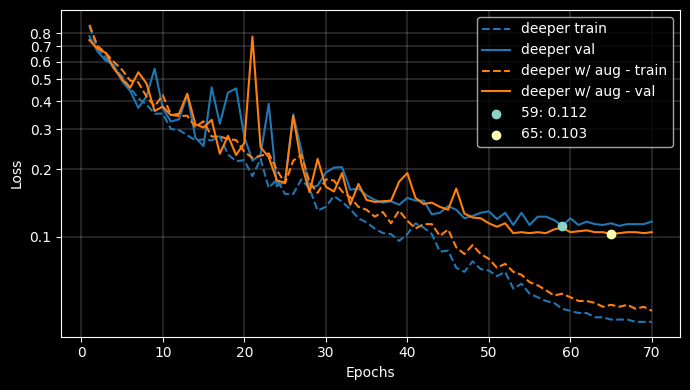

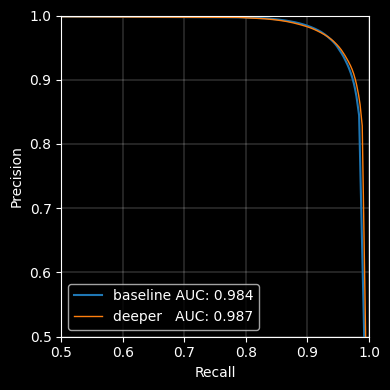

In [33]:
checkpoint_folder = "checkpoints"

exp_name_v1 = "BUnet_d4_c32_a0_SOneCycle"
exp_name_v2 = "BUnet_d4_c32_a2_SOneCycle"

eps_v1, tr_loss_v1, val_loss_v1 = extract_log_data(f"{checkpoint_folder}/{exp_name_v1}.log")
eps_v2, tr_loss_v2, val_loss_v2 = extract_log_data(f"{checkpoint_folder}/{exp_name_v2}.log")

min_loss_v1, best_epoch_v1 = get_best_epoch(eps_v1, val_loss_v1)
min_loss_v2, best_epoch_v2 = get_best_epoch(eps_v2, val_loss_v2)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(eps_v1, tr_loss_v1, '--', color='#1f77b4', label="deeper train")
ax.plot(eps_v1, val_loss_v1, '-', color='#1f77b4', label="deeper val")
ax.plot(eps_v2, tr_loss_v2, '--', color='#ff7f0e', label="deeper w/ aug - train")
ax.plot(eps_v2, val_loss_v2, '-', color='#ff7f0e', label="deeper w/ aug - val")
ax.scatter(best_epoch_v1, min_loss_v1, zorder=10, label=f"{best_epoch_v1}: {min_loss_v1:.3f}")
ax.scatter(best_epoch_v2, min_loss_v2, zorder=10, label=f"{best_epoch_v2}: {min_loss_v2:.3f}")
ax.grid(which="major", linestyle='-', linewidth=0.2)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
ax.set_yscale("log")
ax.set_yticks(np.arange(0.1, 0.9, step=0.1))
ax.minorticks_off()
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.tight_layout()
plt.show()
fig.savefig("results/loss_fn.png")

thr_vec = np.arange(0, 1, step=0.001)
tp_v1, fp_v1, fn_v1 = load_tp_fp_fn(exp_name_v1)
tp_v2, fp_v2, fn_v2 = load_tp_fp_fn(exp_name_v2)

precision_v1, recall_v1, f1_v1 = compute_metrics(tp_v1, fp_v1, fn_v1)
precision_v2, recall_v2, f1_v2 = compute_metrics(tp_v2, fp_v2, fn_v2)

auc_v1 = auc_from_pr_curve(precision_v1, recall_v1)
auc_v2 = auc_from_pr_curve(precision_v2, recall_v2)

fig, ax = plt.subplots(figsize=(4,4))
# ax.plot(thr_vec, f1_v1, '--', color='#1f77b4', label="no aug - precision")
# ax.plot(thr_vec, recall_v1, '-', color='#1f77b4', label="no aug - recall")
# ax.plot(thr_vec, f1_v2, '--', color='#ff7f0e', label="aug - precision")
# ax.plot(thr_vec, recall_v2, '-', color='#ff7f0e', label="aug - recall")
ax.plot(recall_v1, precision_v1, '-', color='#1f77b4', label=f"baseline AUC: {auc_v1:.3f}", linewidth=1.5)
ax.plot(recall_v2, precision_v2, '-', color='#ff7f0e', label=f"deeper   AUC: {auc_v2:.3f}", linewidth=1)
ax.grid(which="major", linestyle='-', linewidth=0.2)
ax.legend(loc='lower left')
# ax.set_ylabel("Metric")
# ax.set_xlabel("Threshold")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
ax.set_xlim([0.5, 1])
ax.set_ylim([0.5, 1])
# ax.set_xticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.show()
fig.savefig("results/compare_roc.png")
plt.show()